### This solution is inspired by [Alexandru Papiu](https://www.kaggle.com/code/apapiu/regularized-linear-models)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Imports & EDA

In [2]:
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

train_test_data = pd.concat([train, test],axis=0,ignore_index=True)
train_test_data.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  2919.000000  2919.000000  2433.000000    2919.000000  2919.000000   
mean   1460.000000    57.137718    69.305795   10168.114080     6.089072   
std     842.787043    42.517628    23.344905    7886.996359     1.409947   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     730.500000    20.000000    59.000000    7478.000000     5.000000   
50%    1460.000000    50.000000    68.000000    9453.000000     6.000000   
75%    2189.500000    70.000000    80.000000   11570.000000     7.000000   
max    2919.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  2919.000000  2919.000000   2919.000000  2896.000000  2918.000000  ...   
mean      5.564577  1971.312778   1984.264474   102.201312   441.423235  ...   
std       1.113131    30.291442     20.894344   179.334253   455.610826  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1953.500000   1965.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1993.000000     0.000000   368.500000  ...   
75%       6.000000  2001.000000   2004.000000   164.000000   733.000000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  2919.000000  2919.000000    2919.000000  2919.000000  2919.000000   
mean     93.709832    47.486811      23.098321     2.602261    16.062350   
std     126.526589    67.575493      64.244246    25.188169    56.184365   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    26.000000       0.000000     0.000000     0.000000   
75%     168.000000    70.000000       0.000000     0.000000     0.000000   
max    1424.000000   742.000000    1012.000000   508.000000   576.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  2919.000000   2919.000000  2919.000000  2919.000000    1460.000000  
mean      2.251799     50.825968     6.213087  2007.792737  180921.195890  
std      35.663946    567.402211     2.714762     1.314964   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     4.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     800.000000  17000.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

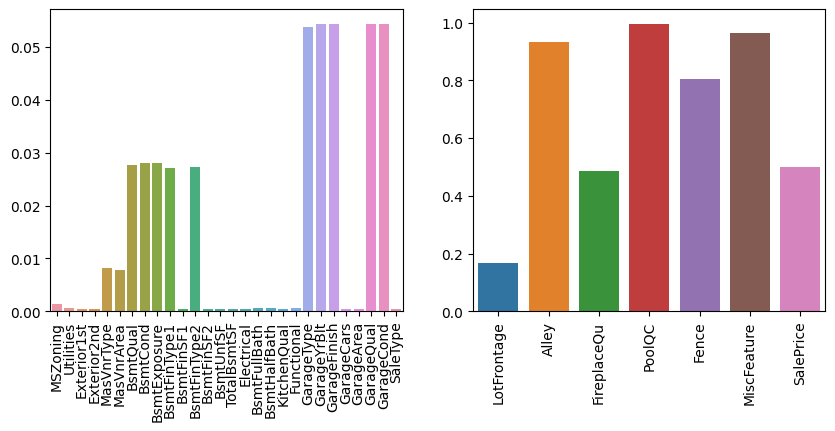

In [3]:
# Missing ratio of each feature
missing_ratio = train_test_data.isnull().sum() / len(train_test_data)
missing_ratio = missing_ratio[missing_ratio.values>0]
missing_ratio_low = missing_ratio[missing_ratio.values<=0.1]
missing_ratio_high = missing_ratio[missing_ratio.values>0.1]

fig = plt.figure(figsize=(10,4),dpi=100)
plt.subplot(1,2,1)
sns.barplot(x=missing_ratio_low.index,y=missing_ratio_low.values)
plt.xticks(rotation=90)
plt.subplot(1,2,2)
sns.barplot(x=missing_ratio_high.index,y=missing_ratio_high.values)
plt.xticks(rotation=90);

<AxesSubplot:>

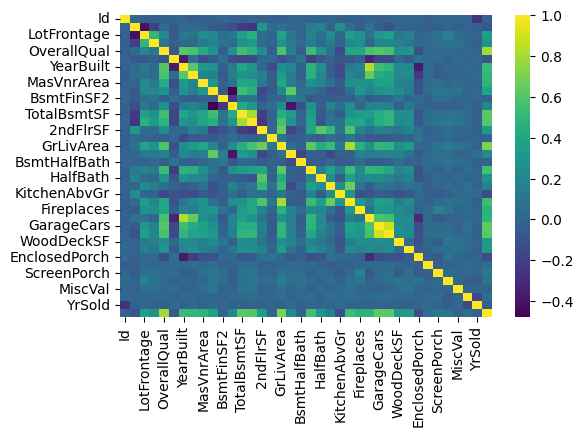

In [4]:
fig = plt.figure(figsize=(6,4),dpi=100)
sns.heatmap(train_test_data.corr(),cmap='viridis')

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

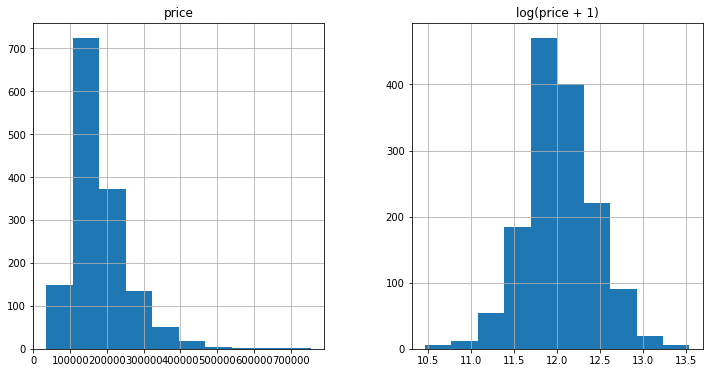

In [5]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

### Feature Engineering

In [6]:
# High missing ratio features
missing_ratio_high.index

# Fill in missing rows
train_test_data['LotFrontage'] = train_test_data.groupby('Neighborhood')['LotFrontage'].transform(lambda val: val.fillna(val.mean()))
train_test_data['MiscFeature'] = train_test_data['MiscFeature'].replace(to_replace=['Gar2','Othr','TenC'],value='Other')
train_test_data['MiscFeature'] = train_test_data['MiscFeature'].fillna(value='Other')

# Drop some features with high missing ratio
train_test_data = train_test_data.drop(['Alley','FireplaceQu','PoolQC','Fence','SalePrice'],axis=1)

# Low missing ratio features
missing_ratio_low.index

# Fill in missing rows
train_test_data['MSZoning'] = train_test_data['MSZoning'].fillna(value='RL')
train_test_data['Exterior1st'] = train_test_data['Exterior1st'].fillna(value='VinylSd')
train_test_data['Exterior2nd'] = train_test_data['Exterior2nd'].fillna(value='VinylSd')
train_test_data['MasVnrType'] = train_test_data['MasVnrType'].fillna(value='None')
train_test_data['MasVnrArea'] = train_test_data['MasVnrArea'].fillna(value=0)
train_test_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = train_test_data[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']].fillna(value='None')
train_test_data[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = train_test_data[['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(value=0)
train_test_data['Electrical'] = train_test_data['Electrical'].fillna(value='SBrkr')
train_test_data['KitchenQual'] = train_test_data['KitchenQual'].fillna(value='TA')
train_test_data['Functional'] = train_test_data['Functional'].fillna(value='Typ')
train_test_data[['GarageType','GarageFinish','GarageQual','GarageCond']] = train_test_data[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna(value='None')
train_test_data[['GarageYrBlt','GarageCars','GarageArea']] = train_test_data[['GarageYrBlt','GarageCars','GarageArea']].fillna(value=0)
train_test_data['SaleType'] = train_test_data['SaleType'].fillna(value='WD')

# Drop some features
train_test_data = train_test_data.drop(['Utilities','Id'],axis=1)

In [7]:
# Data Scaling

# Log transform the target
train["SalePrice"] = np.log1p(train["SalePrice"])

# Log transform skewed numeric features
numeric_feats = train_test_data.dtypes[train_test_data.dtypes != "object"].index

skewed_feats = train_test_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train_test_data[skewed_feats] = np.log1p(train_test_data[skewed_feats])

In [8]:
train_test_data_dum = pd.get_dummies(train_test_data,drop_first=True)
train_test_data_dum

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       4.110874     4.189655  9.042040            7            5       2003   
1       3.044522     4.394449  9.169623            6            8       1976   
2       4.110874     4.234107  9.328212            7            5       2001   
3       4.262680     4.110874  9.164401            7            5       1915   
4       4.110874     4.442651  9.565284            8            5       2000   
...          ...          ...       ...          ...          ...        ...   
2914    5.081404     3.091042  7.568896            4            7       1970   
2915    5.081404     3.091042  7.546974            4            5       1970   
2916    3.044522     5.081404  9.903538            5            7       1960   
2917    4.454347     4.143135  9.253591            5            5       1992   
2918    4.110874     4.317488  9.172431            7            5       1993   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0             2003    5.283204    6.561031         0.0  ...               0   
1             1976    0.000000    6.886532         0.0  ...               0   
2             2002    5.093750    6.188264         0.0  ...               0   
3             1970    0.000000    5.379897         0.0  ...               0   
4             2000    5.860786    6.486161         0.0  ...               0   
...            ...         ...         ...         ...  ...             ...   
2914          1970    0.000000    0.000000         0.0  ...               0   
2915          1970    0.000000    5.533389         0.0  ...               0   
2916          1996    0.000000    7.110696         0.0  ...               0   
2917          1992    0.000000    5.823046         0.0  ...               0   
2918          1994    4.553877    6.632002         0.0  ...               0   

      SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0                  0             0             0            1   
1                  0             0             0            1   
2                  0             0             0            1   
3                  0             0             0            1   
4                  0             0             0            1   
...              ...           ...           ...          ...   
2914               0             0             0            1   
2915               0             0             0            1   
2916               0             0             0            1   
2917               0             0             0            1   
2918               0             0             0            1   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
2914                      0                     0                     0   
2915                      0                     0                     0   
2916                      0                     0                     0   
2917                      0                     0                     0   
2918                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...                    ...  
2914                     1                      0 

In [9]:
X = train_test_data_dum.iloc[:1460]
X_submission = train_test_data_dum.iloc[1460:]
y = train['SalePrice']

### Modeling

In [10]:
# Grid Search for Elastic Net
# from sklearn.linear_model import ElasticNet
# from sklearn.model_selection import GridSearchCV
# base_elastic_model = ElasticNet(max_iter=5000)
# param_grid = {'alpha':[0.001,0.01,0.1,1,5,10,50,100],'l1_ratio':[0.01,0.05,0.1,0.5,0.7,0.9,0.95,0.99,1]}
# grid_model = GridSearchCV(estimator=base_elastic_model,param_grid=param_grid,
#                          scoring='neg_mean_squared_error',cv=5,verbose=1)
# grid_model.fit(X,y)
# print('Best parameter:',grid_model.best_params_)
# print('Best score:',grid_model.best_score_)

In [11]:
# Best model for Elastic Net
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(max_iter=5000,alpha=0.001,l1_ratio=0.7)
elastic_net.fit(X,y)
elastic_net_preds = np.expm1(elastic_net.predict(X_submission))

In [12]:
# Parameter tuning for XGBoost
# import xgboost as xgb
# dtrain = xgb.DMatrix(X, label = y)
# dtest = xgb.DMatrix(X_submission)

# params = {"max_depth":2, "eta":0.1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
# model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [13]:
# Best model for XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
xgb_model.fit(X, y)
xgb_model_preds = np.expm1(xgb_model.predict(X_submission))

<AxesSubplot:xlabel='XGB', ylabel='ElasticNet'>

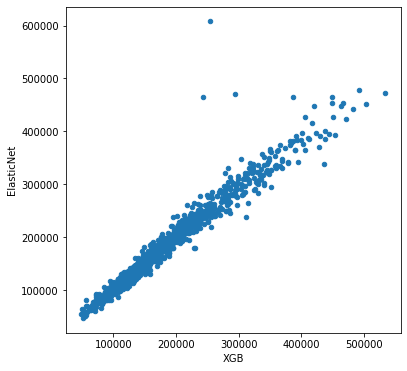

In [14]:
# Plot predictions from both methods
predictions = pd.DataFrame({"XGB":xgb_model_preds, "ElasticNet":elastic_net_preds})
predictions.plot(figsize=(6,6),x = "XGB", y = "ElasticNet", kind = "scatter")

In [15]:
predictions = 0.25*xgb_model_preds + 0.75*elastic_net_preds
output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
output

Id      SalePrice
0     1461  115150.829585
1     1462  152174.787934
2     1463  182519.311832
3     1464  197439.894569
4     1465  201350.556514
...    ...            ...
1454  2915   88053.690427
1455  2916   86063.431422
1456  2917  167725.445869
1457  2918  117099.800302
1458  2919  229356.558993

[1459 rows x 2 columns]